# Example notebook : Monitoring with binary classification

For the monitoring case we need to evaluate differents possibilities, each possibility considered that you have some new input X and associated predictions y :


1. You have only new X, predictions and y_real.
    
2. You have new X, predictions and original dataset bias metrics.

3. You have both the real ouput and original metrics. **==>** You can compare model, dataset bias and model performance.

## Load packages

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from transparentai.monitoring import Monitoring

from transparentai.models import ClassificationModel
from transparentai.datasets import StructuredDataset, load_adult
from transparentai.fairness import DatasetBiasMetric, ModelBiasMetric
from transparentai.utils import encode_categorical_vars

## Prepare data

In [2]:
adult = load_adult()
adult['age category'] = np.where(adult['age'] < 26, 'Young',
                                 np.where(adult['age'] < 61, 'Adult','Elder'))

target='income'

# This variable will be used by Monitoring object
privileged_groups = {
    'age category': ['Adult'],
    'marital-status': ['Married-civ-spouse','Married-AF-spouse'],
    'race': ['White'],
    'gender': ['Male']
}

In [3]:
target_value = {'>50K':1, '<=50K':0}
adult[target] = adult[target].replace(target_value)
adult, encoders = encode_categorical_vars(adult)

In [4]:
adult_train = adult.sample(frac=0.8)

# data that will be considered as new data (after releasing the model) 
adult_new = adult.loc[~adult.index.isin(adult_train.index)]

adult_train.shape, adult_new.shape

((39074, 16), (9768, 16))

### Create model

In [5]:
X, y = adult_train.drop(columns=target), adult_train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Format and retrieve information of training data

In [7]:
for var in encoders:
    X_train[var] = encoders[var].inverse_transform(X_train[var])

df = X_train.copy()
target_value = {0:'<=50K', 1:'>50K'}
df['income'] = y_train.replace(target_value)
dataset = StructuredDataset(df=df,target='income')

/home/lauga/Documents/workspace/transparentai/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
favorable_label = '>50K'
dataset_bias = DatasetBiasMetric(dataset=dataset, privileged_groups=privileged_groups,
                                 favorable_label=favorable_label)

In [9]:
model = ClassificationModel(model=clf)
model.compute_scores(X=X_test, y=y_test)

preds = pd.Series(clf.predict(X_test)).replace(target_value)

In [10]:
for var in encoders:
    X_test[var] = encoders[var].inverse_transform(X_test[var])

df = X_test.copy()
target_value = {0:'<=50K', 1:'>50K'}
df['income'] = y_test.replace(target_value)
dataset = StructuredDataset(df=df,target='income')

/home/lauga/Documents/workspace/transparentai/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
model_bias = ModelBiasMetric(dataset=dataset, preds=preds,
                             privileged_groups=privileged_groups,
                             favorable_label=favorable_label)

In [12]:
metrics_bias_data = dataset_bias.metrics_to_json()
metrics_bias_model = model_bias.metrics_to_json()
metrics_performance = model.scores_to_json()

orig_metrics = {
    'performance':metrics_performance,
    'bias_dataset':metrics_bias_data,
    'bias_model':metrics_bias_model
}

In [13]:
orig_metrics

{'performance': {'accuracy': 0.855447848003102,
  'f1': 0.8516352982783291,
  'precision': 0.8501913397066653,
  'recall': 0.855447848003102,
  'roc_auc': 0.9053920309727332},
 'bias_dataset': {'age category': {'>50K': {'Disparate impact': 0.26448799770214804,
    'Statistical parity difference': -0.21953349270630057}},
  'marital-status': {'>50K': {'Disparate impact': 0.14721814054324484,
    'Statistical parity difference': -0.38049381837807456}},
  'race': {'>50K': {'Disparate impact': 0.6172155465013939,
    'Statistical parity difference': -0.0972164588769116}},
  'gender': {'>50K': {'Disparate impact': 0.3673470749569934,
    'Statistical parity difference': -0.19203984097701332}}},
 'bias_model': {'age category': {'>50K': {'Disparate impact': 0.19901667029216866,
    'Statistical parity difference': -0.20662799906473683,
    'Equal opportunity difference': -0.11920280467662014,
    'Average abs odds difference': 0.10149901605663132,
    'Theil index': 0.11460972789258835}},
  'm

### Format new data

In [14]:
new_X = adult_new.drop(columns=target)
new_y_real = adult_new[target].replace({0:'<=50K',1:'>50K'})
new_y_preds = pd.Series(clf.predict(new_X)).replace({0:'<=50K',1:'>50K'})

In [15]:
for var in encoders:
    new_X[var] = encoders[var].inverse_transform(new_X[var])

## Define alert threshold

This dictionnary can be set to be sure that your model is still good.

In [16]:
alert_threshold = {
    'accuracy':0.8,
    'f1':0.7,
    'precision':0.8,
    'recall':0.9
}                    

## Case 1 : Only new X, predictions and y_real

In [17]:
monitoring = Monitoring(X=new_X, y_preds=new_y_preds, 
                        y_real=new_y_real,
                        privileged_groups=privileged_groups,
                        alert_threshold=alert_threshold,
                        model_type='classification')

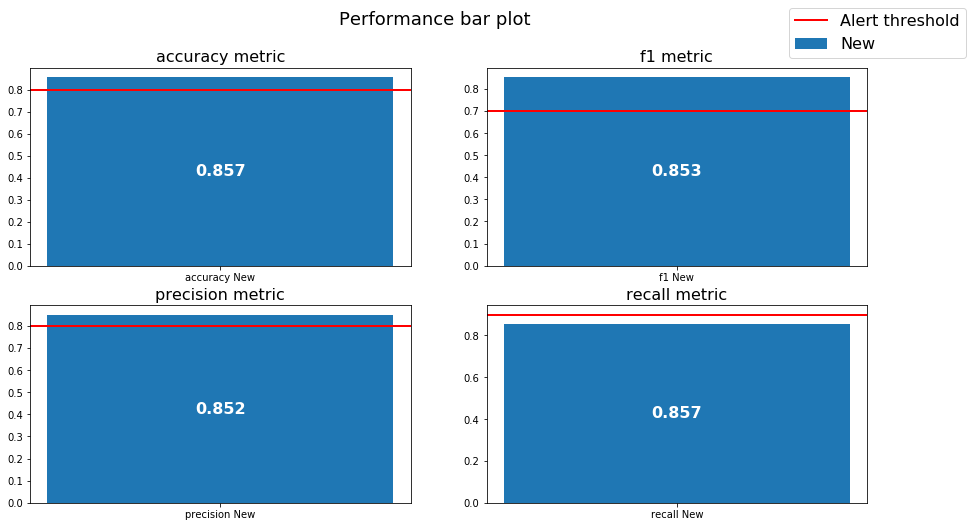

In [18]:
monitoring.plot_perfomance()

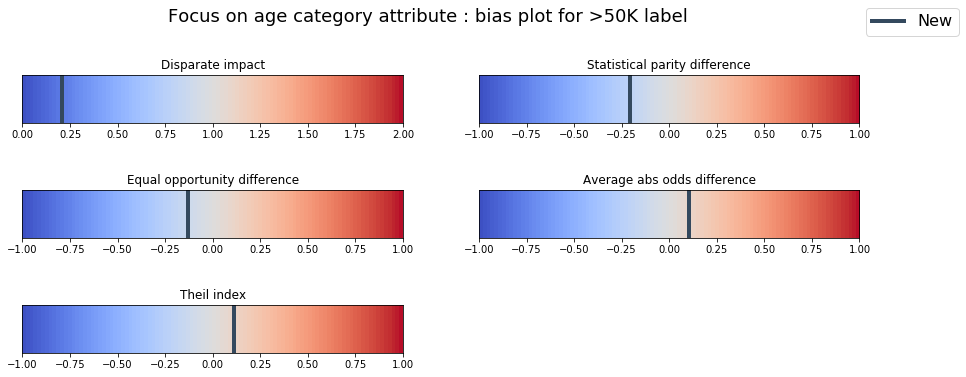

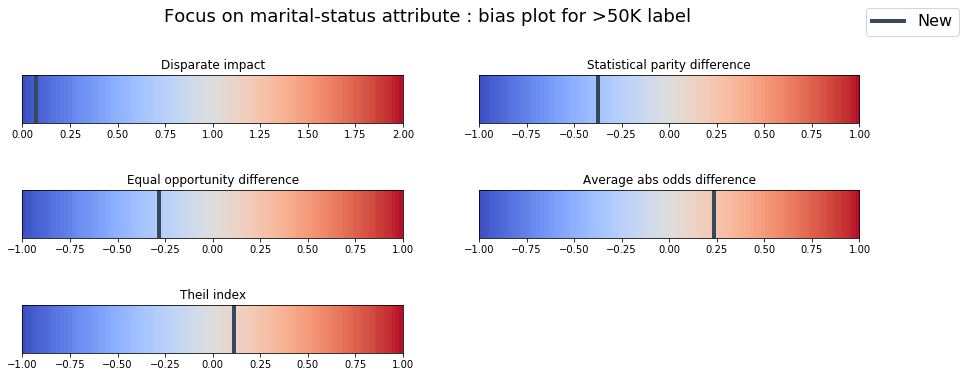

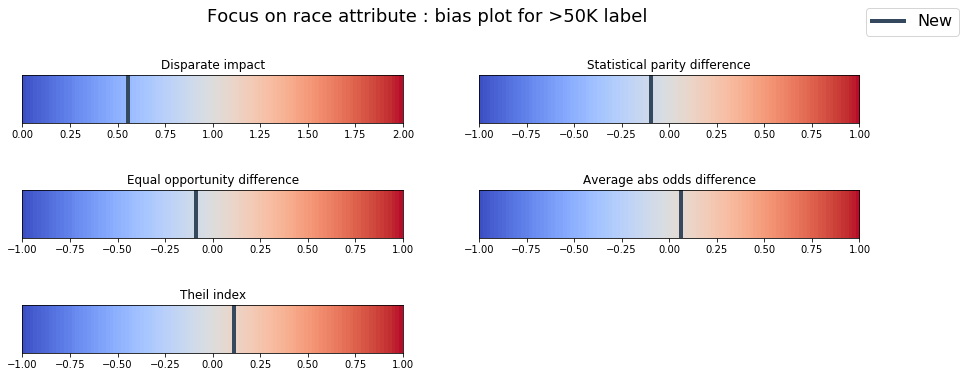

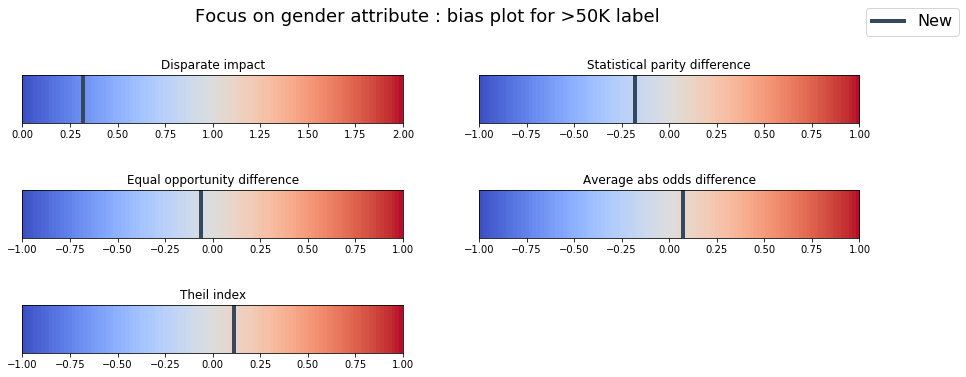

In [19]:
monitoring.plot_model_bias(target_value='>50K')

## Case 2 : New X, predictions and original dataset bias metrics

In [20]:
monitoring = Monitoring(X=new_X, y_preds=new_y_preds, 
                        orig_metrics=orig_metrics,
                        privileged_groups=privileged_groups,
                        alert_threshold=alert_threshold,
                        model_type='classification')

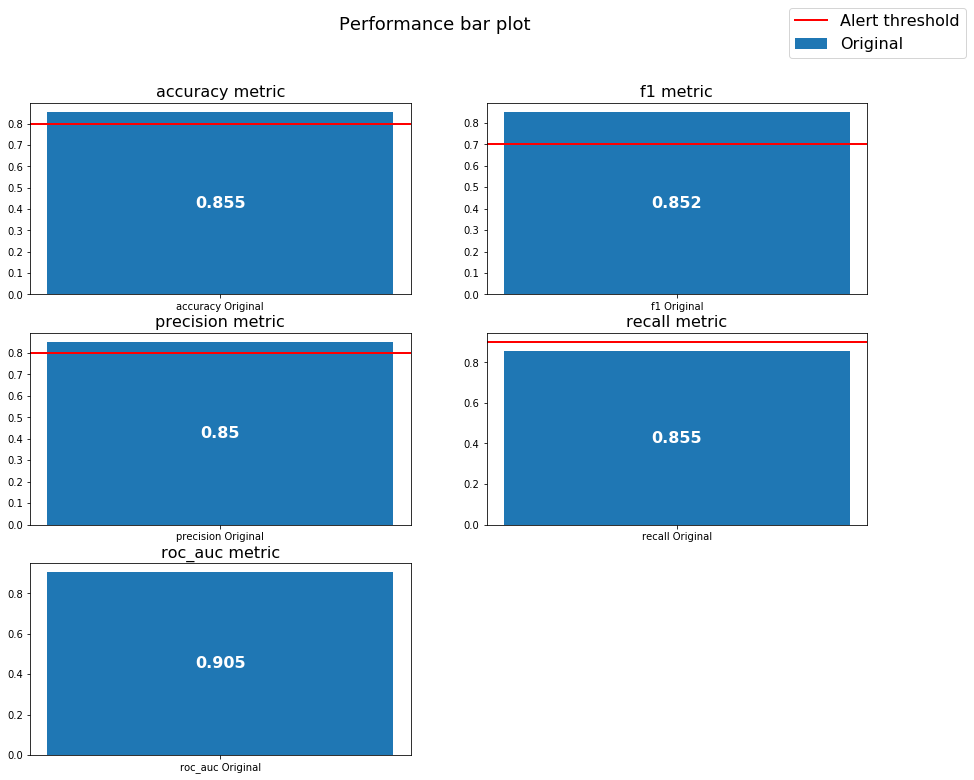

In [21]:
monitoring.plot_perfomance()

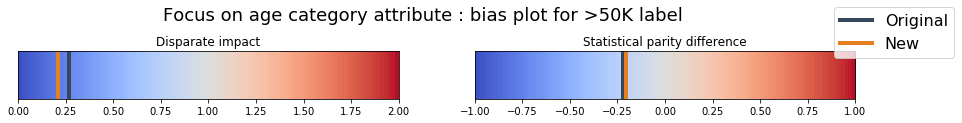

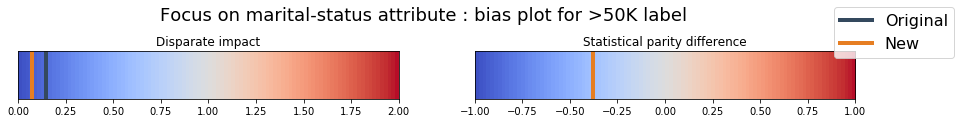

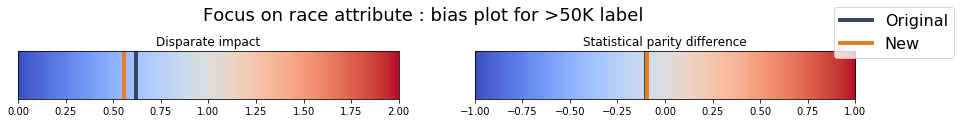

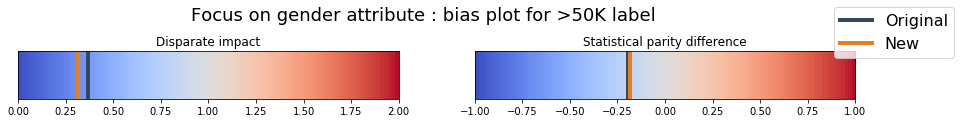

In [22]:
monitoring.plot_dataset_bias(target_value='>50K')

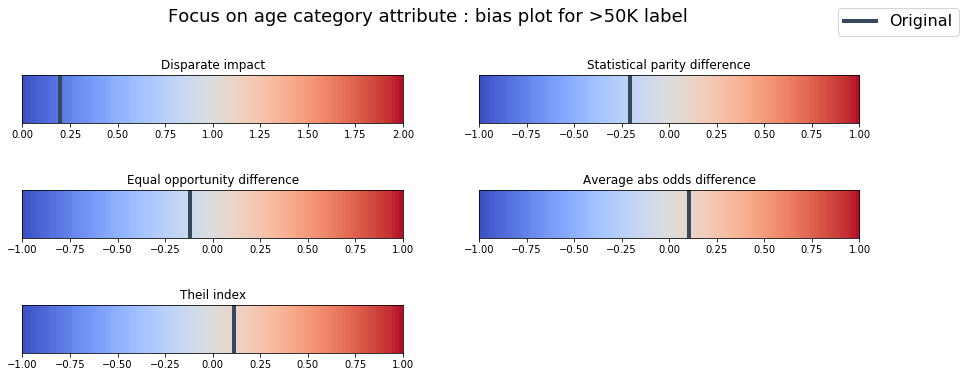

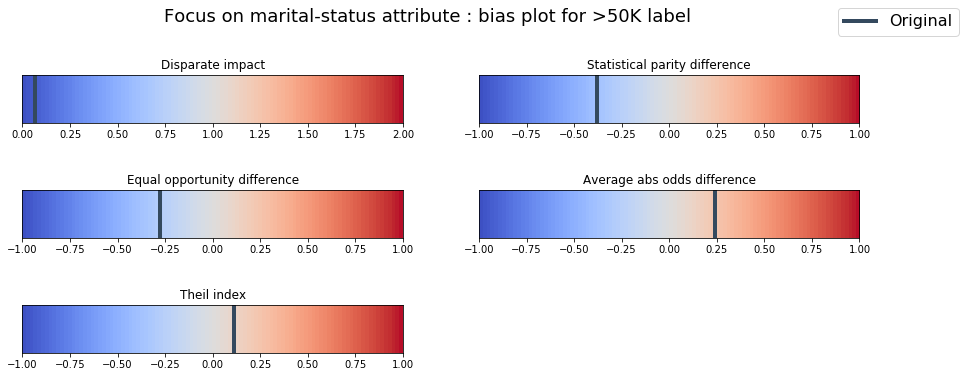

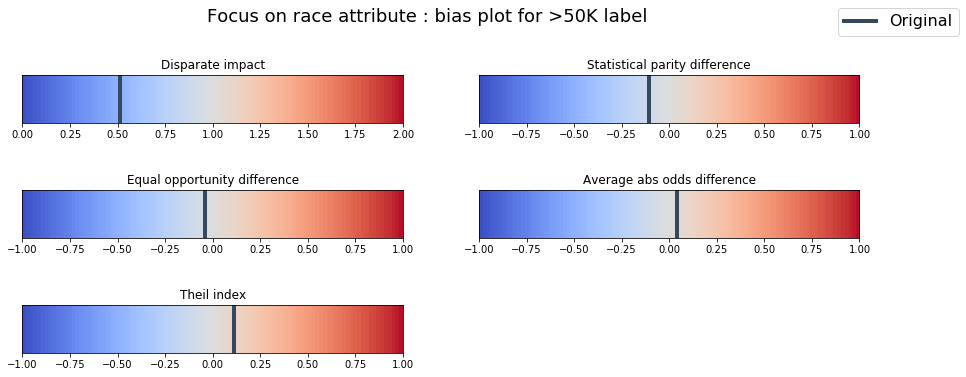

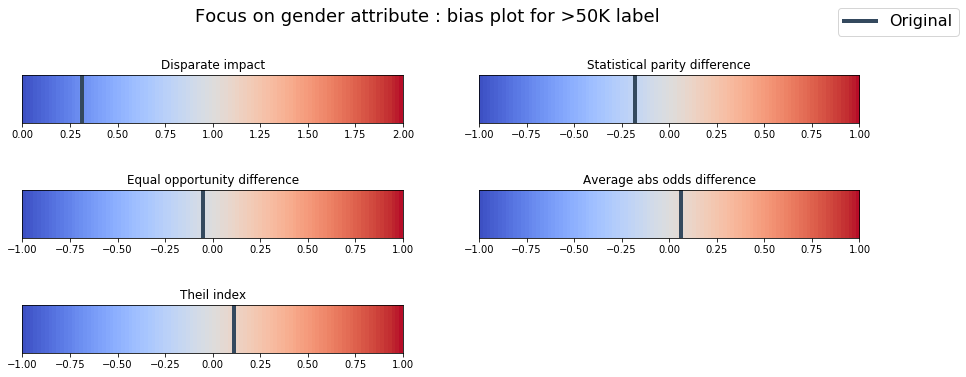

In [23]:
monitoring.plot_model_bias(target_value='>50K')

## Case 3 : New X, predictions, y real and original metrics

In [24]:
monitoring = Monitoring(X=new_X, y_preds=new_y_preds, 
                        y_real=new_y_real,
                        orig_metrics=orig_metrics,
                        privileged_groups=privileged_groups,
                        alert_threshold=alert_threshold,
                        model_type='classification')

/home/lauga/Documents/workspace/transparentai/venv/lib/python3.7/site-packages/transparentai-0.0.2-py3.7.egg/transparentai/monitoring/monitoring.py:110: UserWarning: In original performance dict 'roc_auc' key is in but not in the new one.
  f"In original {metric} dict '{k}' key is in but not in the new one.")


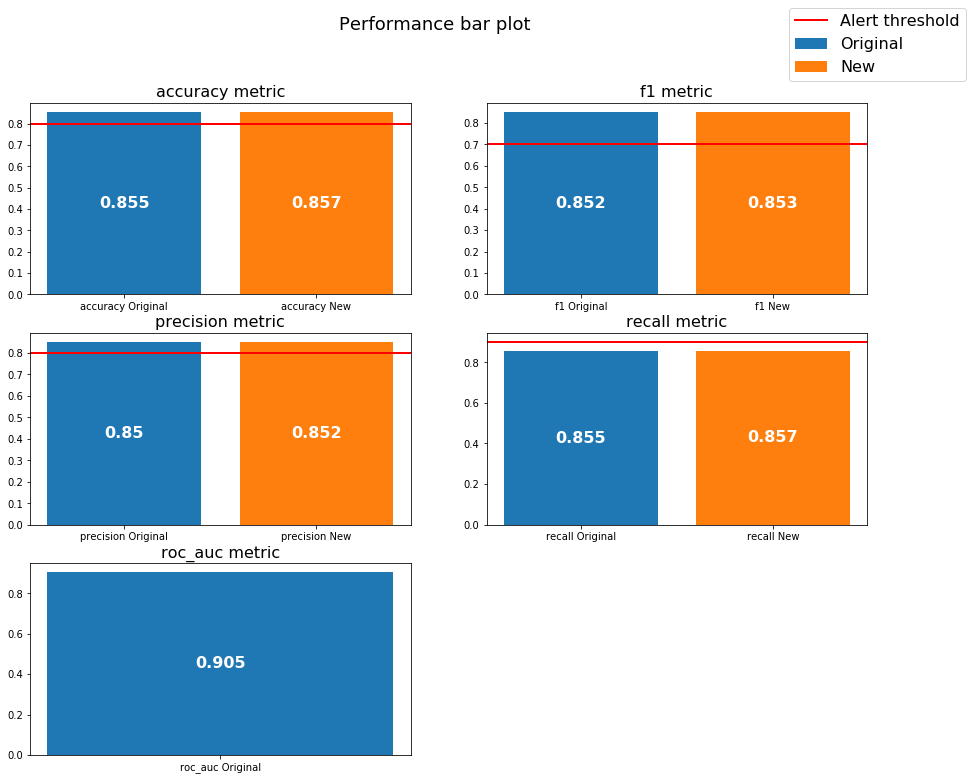

In [25]:
monitoring.plot_perfomance()

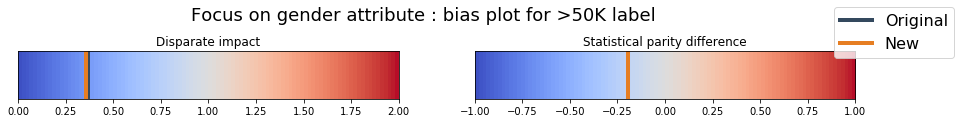

In [26]:
monitoring.plot_dataset_bias(attr='gender',target_value='>50K')

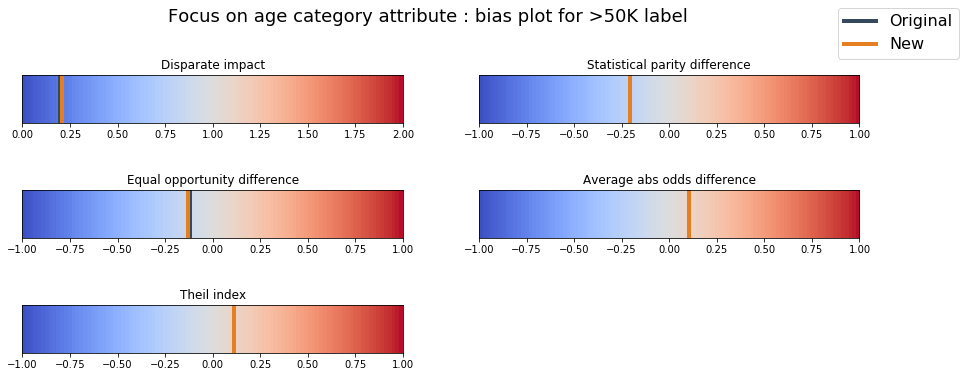

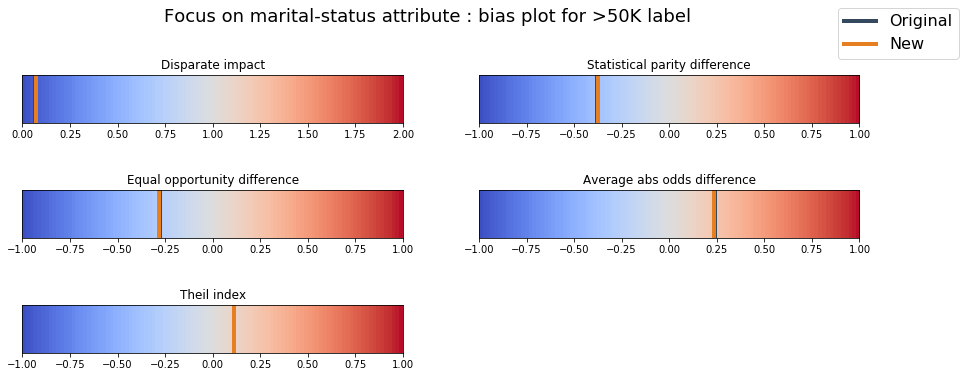

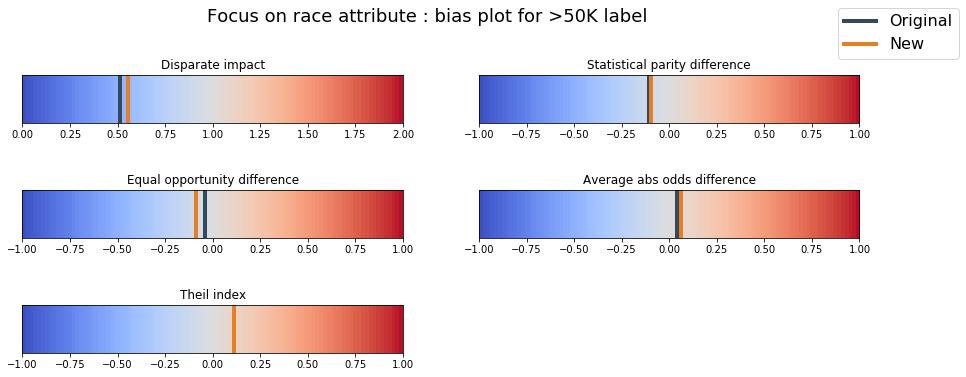

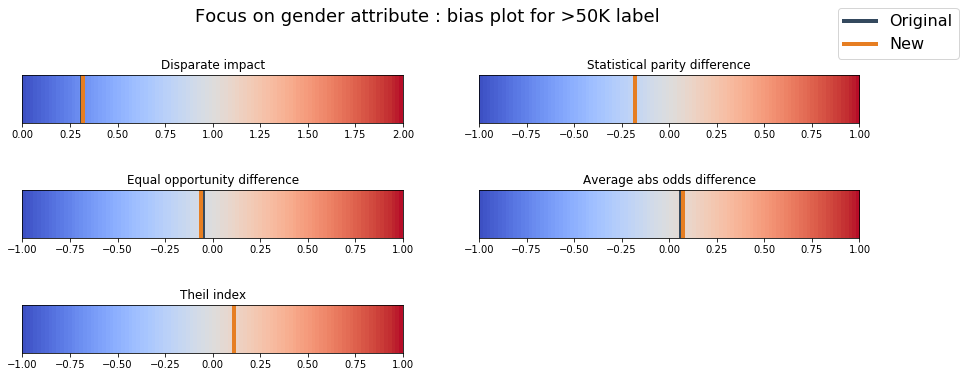

In [27]:
monitoring.plot_model_bias(target_value='>50K')

## The end.